# CLIPasso

### Converting an image to a sketch composed with the given number of lines.

Original Author: [yael-vinker](https://github.com/yael-vinker)

Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/yael-vinker/CLIPasso

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/CLIPasso.ipynb)

In [ ]:
#@title Setup

%tensorflow_version 1.x

!git clone https://github.com/yael-vinker/CLIPasso.git
%cd CLIPasso
!pip install wandb cssutils
!wget \
  'https://docs.google.com/uc?export=download&confirm=t&id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ' \
  -O ./U2Net_/saved_models/u2net.pth
# !pip install -r requirements.txt
# !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html

!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/BachiLi/diffvg
%cd diffvg
!git submodule update --init --recursive
%run setup.py install


import sys
sys.path.append("/content/CLIPasso/diffvg/build/lib.linux-x86_64-3.7")
!pip3 install --upgrade Pillow

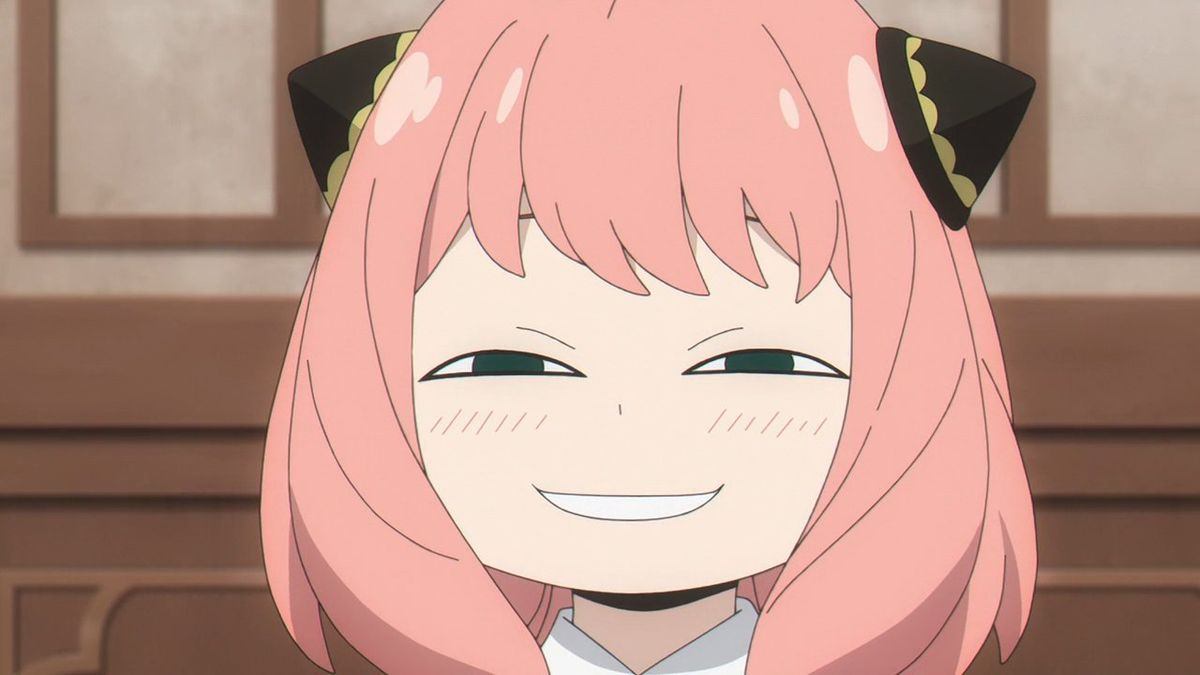

In [6]:
#@title Upload Image

%cd /content/CLIPasso
from google.colab import files
from IPython.display import display, clear_output
from PIL import Image

ff = files.upload()
f_name = list(ff.keys())[0]
display(Image.open(f_name))


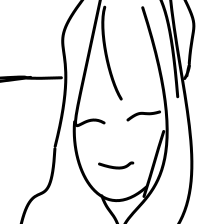

In [8]:
#@title Run


%cd /content/CLIPasso

import os
import sys
sys.path.append("/content/CLIPasso/diffvg/build/lib.linux-x86_64-3.7")
from shutil import copyfile
from IPython.display import SVG

import numpy as np


num_strokes =   16#@param {type:"integer"}


basename = os.path.splitext(f_name)[0]
output_dir = './results'
os.makedirs(output_dir, exist_ok=True)
seeds = list(range(0, 3 * 1000, 1000))
losses_all = {}
for idx, seed in enumerate(seeds):
  print(f'{idx+1}/{len(seeds)}')
  wandb_name = f"{basename}_{num_strokes}strokes_seed{seed}"

  %run painterly_rendering.py \
    "$f_name" \
    --num_paths $num_strokes \
    --output_dir ./results \
    --wandb_name $wandb_name \
    --num_iter 2000 \
    --save_interval 10 \
    --seed $seed \
    --use_gpu 1 \
    --fix_scale 0 \
    --mask_object 0 \
    --mask_object_attention 0 \
    --display_logs 1 \
    --display 0

  config = np.load(f"{output_dir}/{wandb_name}/config.npy", allow_pickle=True)[()]
  loss_eval = np.array(config['loss_eval'])
  inds = np.argsort(loss_eval)
  losses_all[wandb_name] = loss_eval[inds][0]

sorted_final = dict(sorted(losses_all.items(), key=lambda item: item[1]))
copyfile(
  f"{output_dir}/{list(sorted_final.keys())[0]}/best_iter.svg",
  f"{output_dir}/out_best.svg"
)

display(SVG("results/out_best.svg"))

# jpg_path = f"{output_dir}/{wandb_name}/jpg_logs"
# !ffmpeg \
#   -y \
#   -framerate 10 \
#   -pattern_type glob \
#   -i "$jpg_path/iter*.jpg" \
#   -vb 20M \
#   sketch.mp4